In [ ]:
!gdown 1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai
!gdown 1zkfoLAEC_6eOyiHJXM34CE2n9rbSR8G7
!unzip -q /content/PASCAL.zip
!unzip -q /content/hw3_files.zip

Downloading...
From: https://drive.google.com/uc?id=1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai
To: /content/PASCAL.zip
100% 116M/116M [00:04<00:00, 26.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zkfoLAEC_6eOyiHJXM34CE2n9rbSR8G7
To: /content/hw3_files.zip
100% 10.7k/10.7k [00:00<00:00, 50.4MB/s]


In [ ]:

%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import scipy.io
import cv2
from matplotlib import pyplot as plt
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pascal_dataset import PASCALDataset
import utils
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import copy
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from collections import Counter
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from torchvision.utils import draw_bounding_boxes
from collections import Counter
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


## Load Dataset

In [ ]:
class_names = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane']
dataset_train = PASCALDataset('PASCAL/train/')
dataset_val = PASCALDataset('PASCAL/val/')
dataset_test = PASCALDataset('PASCAL/test')

In [ ]:
image, target = dataset_train[3]
target

{'boxes': tensor([[104.,  61., 476., 257.]]),
 'labels': tensor([5]),
 'image_id': tensor([3]),
 'area': tensor([72912.]),
 'iscrowd': tensor([0])}

In [ ]:
image = (image*255.).type(torch.uint8)

## Draw a Sample Image

In [ ]:
def draw_box_legend(draw, boxes, labels, font, text_color='black'):
    for i in range(len(labels)):
          x1, y1, x2, y2 = boxes[i]
          text = class_names[labels[i]] 
          text_width, text_height = draw.textsize(text)
          draw.rectangle(((x2 - text_width - 5, y1), (x2, y1 + text_height + 5)), fill='white')
          draw.text((x2 - text_width - 2, y1 + 2), text, fill=text_color, font=font)

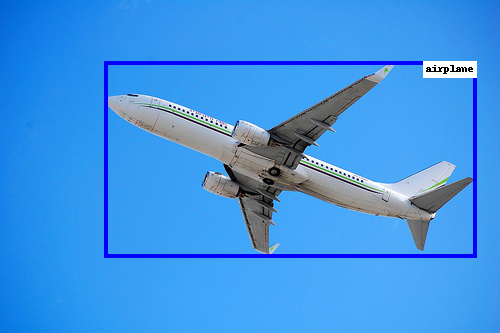

In [ ]:
image_with_bbox = draw_bounding_boxes(
    image.type(torch.uint8), 
    target['boxes'], 
    colors=['blue'], 
    width=4
)
pil_image = transforms.ToPILImage()(image_with_bbox)

draw = ImageDraw.Draw(pil_image)
font = ImageFont.load_default()
draw_box_legend(draw, target['boxes'], target['labels'], font)

pil_image.show()

## Create Data Loader

In [ ]:
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=2, 
    collate_fn=utils.collate_fn
)
data_loader_val = torch.utils.data.DataLoader(dataset_val, 
    batch_size=1, 
    shuffle=True, 
    num_workers=2, 
    collate_fn=utils.collate_fn
)

## Load Model

In [ ]:
EPOCHS = 5
lr = 0.001

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_ftrs = model.roi_heads.box_predictor.bbox_pred.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(num_ftrs, len(class_names))
model = model.to(device) 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 314MB/s]


In [ ]:
def train_phase():
    model.train()

    for images, targets in tqdm(data_loader_train, desc='Training'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                loss = loss_dict['loss_classifier'].add(loss_dict['loss_box_reg'])
                loss = loss.add(loss_dict['loss_objectness'])
                loss = loss.add(loss_dict['loss_rpn_box_reg'])
                loss.backward()
                optimizer.step()
        
    print(f'loss:{loss}')                        

    scheduler.step()

In [ ]:
def validation_phase(best_mAP, best_lr_mAP):
    model.eval()

    coco = get_coco_api_from_dataset(data_loader_val.dataset)
    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco, iou_types)


    for images, targets in tqdm(data_loader_val, desc='Training'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    

        outputs = model(images)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

    epoch_mAP = coco_evaluator.coco_eval['bbox'].stats[0]
    if epoch_mAP > best_lr_mAP:
        best_lr_mAP = epoch_mAP

    if epoch_mAP > best_mAP:
        best_mAP = epoch_mAP
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts , 'best_model.pth')
    return best_mAP, best_lr_mAP

In [ ]:
best_mAP, best_lr_mAP = 0.0, 0.0

optimizer = optim.SGD(
    model.parameters(), 
    lr=lr, 
    momentum=0.9
)
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=7, 
    gamma=0.1
)

best_model_wts = copy.deepcopy(model.state_dict())


for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch+1}/{EPOCHS} ---')
    train_phase()
    best_mAP, best_lr_mAP = validation_phase(best_mAP, best_lr_mAP)

--- Epoch 1/5 ---


Training: 100%|██████████| 251/251 [05:16<00:00,  1.26s/it]


loss:0.2861781716346741
creating index...
index created!


Training: 100%|██████████| 200/200 [00:24<00:00,  8.21it/s]


Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Training: 100%|██████████| 251/251 [05:24<00:00,  1.29s/it]


loss:0.2507893741130829
creating index...
index created!


Training: 100%|██████████| 200/200 [00:24<00:00,  8.25it/s]


Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Training: 100%|██████████| 251/251 [05:27<00:00,  1.31s/it]


loss:0.14126966893672943
creating index...
index created!


Training: 100%|██████████| 200/200 [00:24<00:00,  8.27it/s]


Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Training: 100%|██████████| 251/251 [05:26<00:00,  1.30s/it]


loss:0.16699270904064178
creating index...
index created!


Training: 100%|██████████| 200/200 [00:24<00:00,  8.30it/s]


Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.253
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Training: 100%|██████████| 251/251 [05:27<00:00,  1.30s/it]


loss:0.13938993215560913
creating index...
index created!


Training: 100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import random

selected_image_numbers  = [17, 11, 15]
images_with_targets = [(dataset_test[i][0].to(device), dataset_test[i][1]) for i in selected_image_numbers]
predictions = model([image_with_target[0] for image_with_target in images_with_targets])

In [ ]:
threshold = 0.9

predicted_boxes, predicted_labels = [], []
expected_boxes, expected_labels = [], []
for i in range(len(images_with_targets)):
    idx = predictions[i]['scores'] > threshold
    predicted_boxes.append(predictions[i]['boxes'][idx])
    predicted_labels.append(predictions[i]['labels'][idx])

    expected_boxes.append(images_with_targets[i][1]['boxes'])
    expected_labels.append(images_with_targets[i][1]['labels'])

In [ ]:
def draw_image_legends_on_top(draw, image, labels):
    label_counts = Counter(labels.tolist())

    width, height = image.size
    legend_x = width - 80
    legend_y = 10
    draw.rectangle(((legend_x - 10, legend_y - 5), (legend_x + 70, legend_y + 18 * len(label_counts.keys()))), fill='white')
    for label, count in label_counts.items():
        text = f'{class_names[label]}: {count}'
        text_width, text_height = draw.textsize(text, font=font)
        draw.text((legend_x, legend_y), text, fill='black', font=font)
        legend_y += text_height + 5


In [ ]:
def plot_image_with_bounding_boxes(labels, boxes, random_data):

    result_tensor = draw_bounding_boxes((dataset_test[random_data][0]*255.).type(torch.uint8), boxes, width=4)

    result_image = transforms.ToPILImage()(result_tensor)

    draw = ImageDraw.Draw(result_image)
    font = ImageFont.load_default()

    draw_box_legend(draw, boxes, labels, font)
    draw_image_legends_on_top(draw, result_image, labels)
    

    result_image.show()

--- Predicted Output --- 


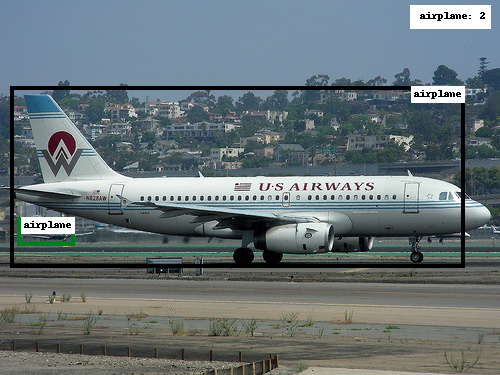

--- Expected Output --- 


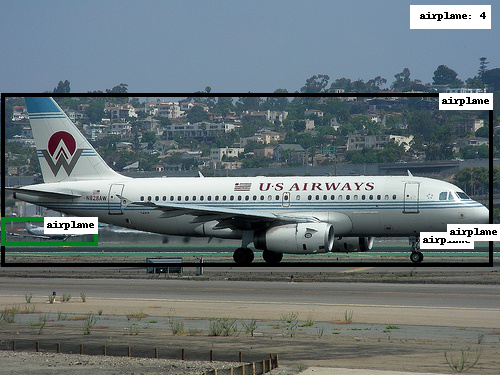

--- Predicted Output --- 


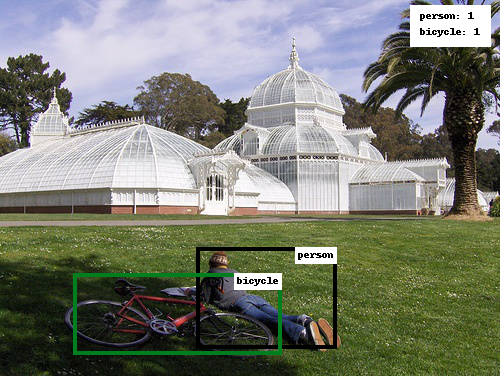

--- Expected Output --- 


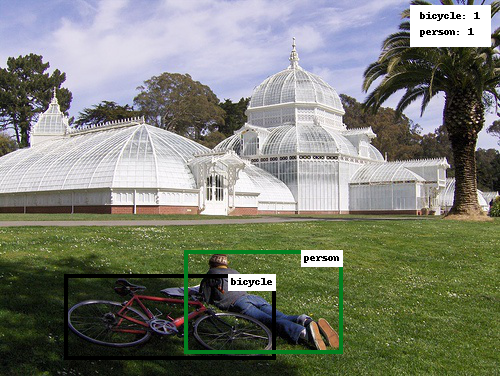

--- Predicted Output --- 


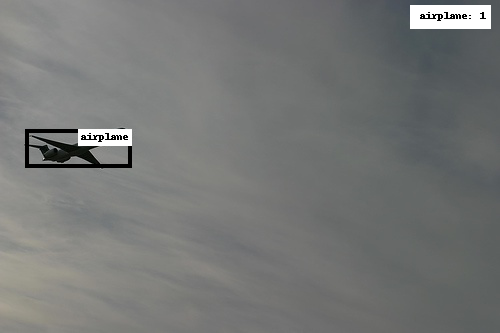

--- Expected Output --- 


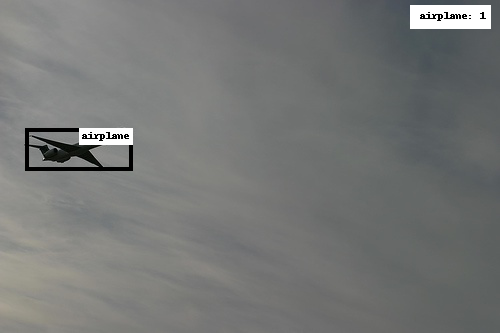

In [ ]:
for j in range(len(images_with_targets)):
    print("--- Predicted Output --- ")
    plot_image_with_bounding_boxes(predicted_labels[j], predicted_boxes[j], selected_image_numbers[j])
    print("--- Expected Output --- ")
    plot_image_with_bounding_boxes(expected_labels[j], expected_boxes[j], selected_image_numbers[j])